### **Mini-project n° 2 – Conditional VAEs**
Groupe 5: Vilde , Laura, Chung et Min-Thi

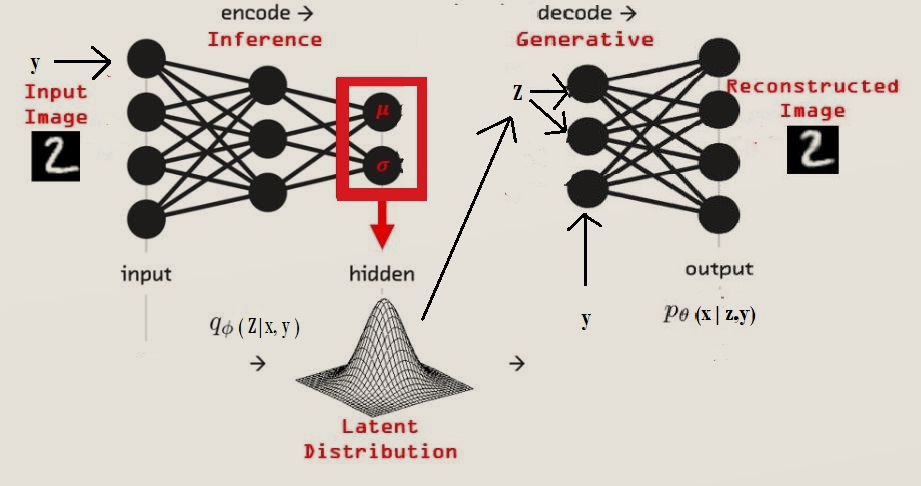

The objective of this mini-project is to define and train a Conditional VAE
(CVAE), by following the instructions below:


**Find resources that explain what a CVAE is, it’s difference with VAEs, the loss functions used to train it etc.**


 **Train a CVAE on the Fashion-MNIST dataset (available to download from
torchvision).**

**Generate 5 new samples for each class of the Fashion-MNIST dataset using
the CVAE.**

**Use Pytorch**

**Explain and argue the different choices you make along the way, in particular:**

  – The choice of the architecture, the layer types, the layer sizes and the
    activations.

  – The choice of the different hyper-parameters: batch size, learning rate,
    number of epochs, regularization weight...

  – The choice of the loss function, the different terms in it, and their
    individual purposes.

**Include links to articles, blog posts, videos... that helped you decide on theabove choices.**

**Include the code of the different trials/experiments that helped you decide
on the above choices.**

**Plot different visualizations for the results: the curves of the different terms in the loss functions, the learnt latent space...**



---



"*The CVAE is a conditional
directed graphical model whose input observations modulate the prior on Gaussian latent variables
that generate the outputs. It is trained to maximize the conditional log-likelihood, and we formulate
the variational learning objective of the CVAE in the framework of stochastic gradient variational
Bayes (SGVB) [16]. In addition, we introduce several strategies, such as input noise-injection and
multi-scale prediction training methods, to build a more robust prediction model.* "

The Conditional Variational Autoencoder (CVAE) loss function is defined as:

$$
\mathcal{L}(x, y; \theta, \phi) = \mathbb{E}_{q_{\phi}(z|x,y)}[\log p_{\theta}(y|x,z)] - \text{KL}(q_{\phi}(z|x,y) \parallel p_{\theta}(z|x))
$$

Where:
- $x$ is the input data,
- $y$ is the conditional target data,
- $q_{\phi}(z|x,y)$ is the encoder (approximate posterior),
- $p_{\theta}(y|x,z)$ is the decoder (likelihood),
- $p_{\theta}(z|x)$ is the prior distribution,
- and $\text{KL}$ is the Kullback-Leibler divergence.


In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26.4M/26.4M [00:01<00:00, 15.6MB/s]


Extracting ../../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 342kB/s]


Extracting ../../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 6.25MB/s]


Extracting ../../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.3MB/s]

Extracting ../../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw



In [3]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=10, condition_dim=10 ):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim #ADDED

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance, ADDING the conditional dimension to the input
        self.fc_mu = nn.Linear(128 * 4 * 4 + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4 + condition_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + condition_dim, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x, c ): # q(z|x, c)
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4) # Flatten the output of the convolutional layers

        x = torch.cat([x, c], dim=1) # ADDED

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c ): # p(x|z, c)

        z = torch.cat([z, c], dim=1) # ADDED

        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.sample(mu, logvar)
        return self.decode(z, c), mu, logvar

# CVAE loss function

In [5]:
# Implement the loss function
def loss_function_cvae(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

# Train the CVAE

In [6]:
# Hyperparameters
latent_dim = 2
condition_dim = 10 ### ????
learning_rate = 1e-3
epochs = 5 # 30 -------------------runne med flere epochs -- lage raskere
beta = 1

cvae = CVAE(latent_dim=latent_dim, condition_dim= condition_dim)
#print(cvae)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0

    for batch_idx, (data, labels) in enumerate(train_loader):  # Assuming labels is the class label

        data = data.to(device)
        labels = labels.to(device)

        # Convert labels to one-hot encoding for the condition vector `c`
        c = F.one_hot(labels, num_classes=condition_dim).float()  # One-hot encoded condition vector

        optimizer.zero_grad()

        recon_batch, mu, logvar = cvae(data, c)

        loss = loss_function_cvae(recon_batch, data, mu, logvar) # using the CVAE loss function

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 275.0445
Epoch 2, Training loss: 257.6512
Epoch 3, Training loss: 255.9883
Epoch 4, Training loss: 255.2228
Epoch 5, Training loss: 254.3592


# Visulaisation

Using the function provided from the course we can now plot the results.

In [16]:
import matplotlib.pyplot as plt

def image_comparison(original_images, reconstructions, n_images=6):
    """Plots the original images and its reconstructions for comparison

    Args:
        original_image (torch.Tensor): The original images
        reconstructions (torch.Tensor): Reconstruction of the original images
    """
    fig, ax = plt.subplots(2, n_images, figsize=(20, 7))

    for i in range(n_images):
        # Plot original images
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

        # Reconstructed images
        ax[1, i].imshow(reconstructions[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1, 0].set_title('Recomstruction')

    plt.tight_layout()
    plt.show()

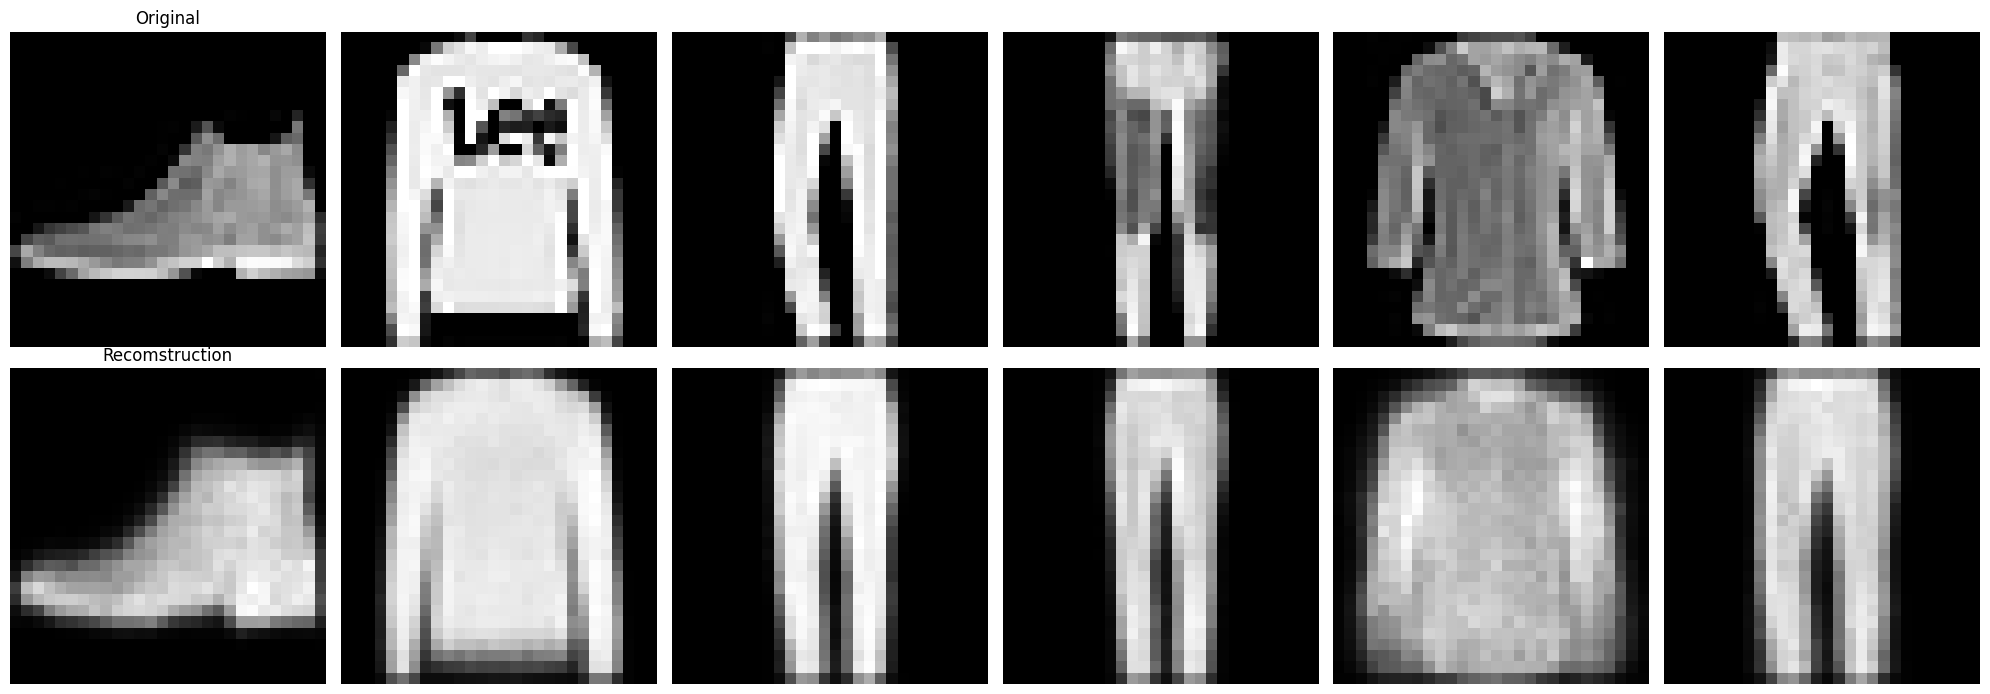

In [17]:
# Select a batch of images from the test dataset
random_images, labels = next(iter(test_loader))

# One-hot encode the labels for the conditional input
c = F.one_hot(labels, num_classes=condition_dim).float().to(device)  # Convert labels to one-hot encoding

# Get the reconstructions of the selected images
recons, _, _ = cvae(random_images.to(device), c)  # Pass entire batch of images and conditional labels

# Reshape the images for plotting
random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)

# Generating 5 new samples

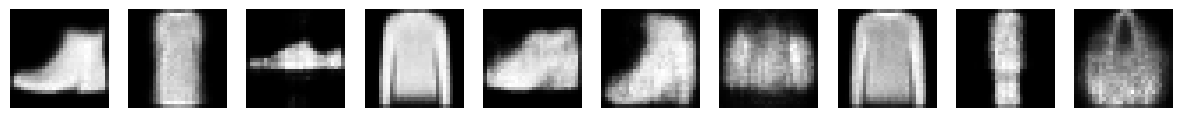

In [22]:
def generate_sample(num_samples=10):
    cvae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)  # Sample random latent vectors

        random_labels = torch.randint(0, condition_dim, (num_samples,)).to(device)  # Random class labels
        c = F.one_hot(random_labels, num_classes=condition_dim).float().to(device)  # One-hot encode labels

        samples = cvae.decode(z,c) # Decode the latent vectors
        samples = samples.cpu().view(num_samples, 1, 28, 28) # Reshape the samples

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

generate_sample()

Sources:

https://proceedings.neurips.cc/paper_files/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf

https://pyro.ai/examples/cvae.html